# CPSC 330 - Applied Machine Learning 

## Homework 2: Decision trees and machine learning fundamentals 
### Associated lectures: [Lectures 2 and 3](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Monday, Jan 22, at 11:59pm. See the [HW schedule](https://github.com/UBC-CS/cpsc330-2023W2#deliverable-due-dates-tentative)**. 

For waitlisted student: if you do not have access, you can ask for help to submit via cpsc330-admin@cs.ubc.ca.


Imports
------

In [1]:
from hashlib import sha1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier

<br><br>

## Instructions

_Points: 3_

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2023W2/blob/master/docs/homework_instructions.md), and the summary at the end of this HW.

You are welcome to broadly discuss questions with your classmates but your final answers must be your own. **We are not allowing group submission for this homework assignment, and the notebook returned must be your own.**

<br><br>

## Introducing the data set
 
For the rest of the lab you'll be using Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset. The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it under the `data` directory. 

> You will not be able to push it to your repository (hopefully) because I have seeded the repository wich `.gitignore`.

<br><br>

## Exercise 1: Exploratory data analysis

### 1.1 Loading the data
_Points: 2_

**Your tasks:**

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column (index=0) of the .csv file should be set as the index.

<div class="alert alert-warning">

Solution_1.1
    
</div>

In [2]:
spotify_df = pd.read_csv("./data/spotify.csv",index_col=0)
spotify_df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


<br><br>

### 1.2 Number of training and test examples

_Points: 2_

**Your tasks:**

Run the following line of code to split the data. How many training and test examples do we have? Store them in variables `n_train_samples` and `n_test_samples`, respectively.  

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [3]:
train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=321)

<div class="alert alert-warning">

Solution_1.2
    
</div>

In [4]:
n_train_samples = train_df.shape[0]
n_test_samples = test_df.shape[0]
print(f"Number of training samples: {n_train_samples}")
print(f"Number of test samples: {n_test_samples}")

Number of training samples: 1613
Number of test samples: 404


<br><br>

#### 1.3

_Points: 3_

**Your tasks:**

1. Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
2. Which feature has the smallest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.

> Note that `describe` returns another DataFrame.


<div class="alert alert-warning">

Solution_1.3
    
</div>

In [5]:
description = train_df.describe()
print(description)
ranges = description.loc['max'] - description.loc['min']
smallest_range_feature = ranges.idxmin()

print()
print(f"Feature with the smallest range: {smallest_range_feature}, Range: {ranges[smallest_range_feature]}")

       acousticness  danceability   duration_ms       energy  \
count   1613.000000   1613.000000  1.613000e+03  1613.000000   
mean       0.185067      0.620076  2.462533e+05     0.681315   
std        0.255838      0.161152  8.056740e+04     0.206964   
min        0.000003      0.148000  1.604200e+04     0.015600   
25%        0.010000      0.514000  1.999040e+05     0.564000   
50%        0.062600      0.634000  2.298590e+05     0.712000   
75%        0.260000      0.739000  2.703330e+05     0.841000   
max        0.994000      0.984000  1.004627e+06     0.997000   

       instrumentalness          key     liveness     loudness         mode  \
count       1613.000000  1613.000000  1613.000000  1613.000000  1613.000000   
mean           0.134317     5.384377     0.191317    -7.095272     0.619343   
std            0.274217     3.653722     0.156071     3.678993     0.485699   
min            0.000000     0.000000     0.018800   -31.082000     0.000000   
25%            0.000000     

<br><br>

### 1.4 Plotting histograms 

_Points: 5_

The starter code below produces histograms for the `loudness` feature which shows the distribution of the feature values in the training set, separated for positive (target=1, i.e., user liked the song) and negative (target=0, i.e., user disliked the song) examples. There are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

> Note: I am using pandas plotting here. You can also use matplotlib if you wish. 

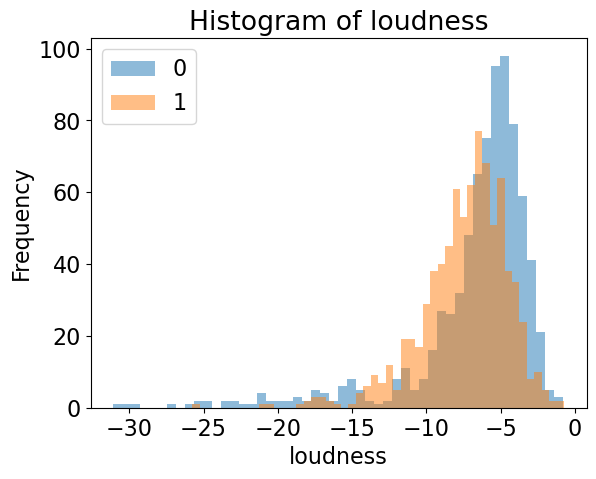

In [6]:
feat = "loudness"
ax = train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
plt.xlabel(feat)
plt.title("Histogram of " + feat)
plt.show()

**Your tasks:**

Create histograms for the following features in the order below.
- acousticness
- danceability
- tempo
- energy
- valence

> To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of your loop, which draws the figure and resets the canvas for your next plot.

<div class="alert alert-warning">

Solution_1.4
    
</div>

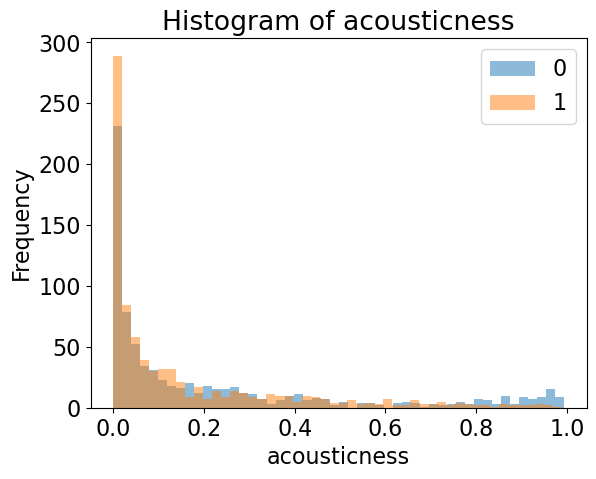

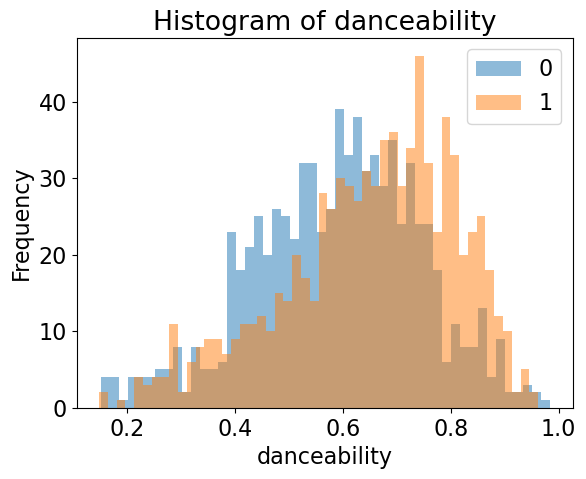

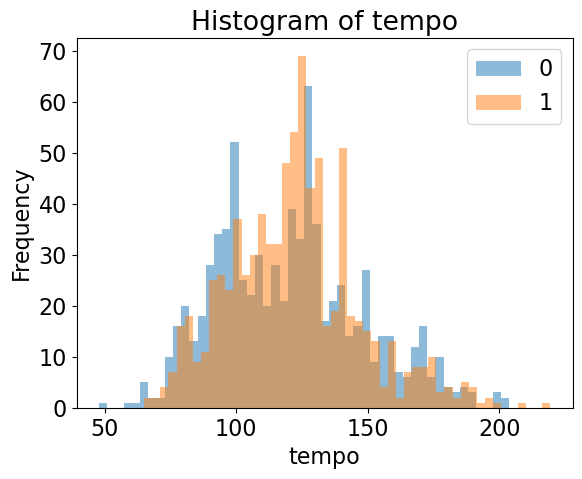

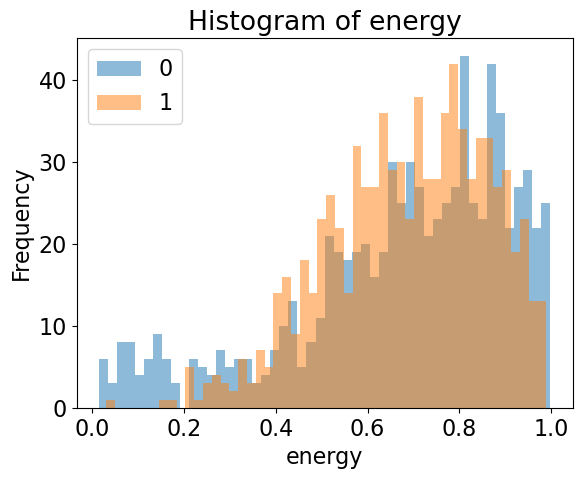

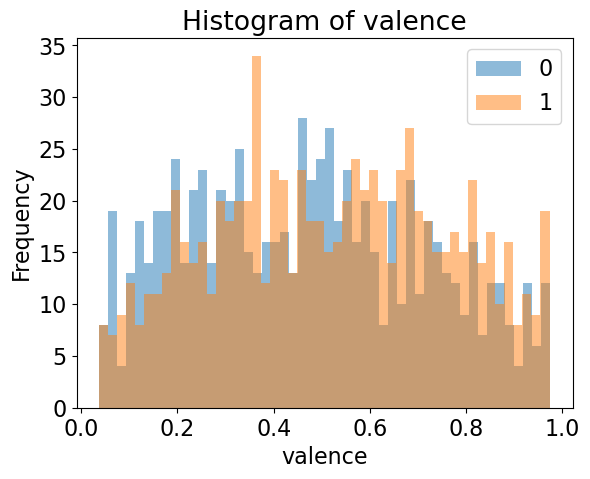

In [7]:
features = ["acousticness", "danceability", "tempo", "energy", "valence"]

for feat in features:
    train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

<br><br>

### 1.5 Identical histograms

_Points: 3_

**Your tasks:**

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?

<div class="alert alert-warning">

Solution_1.5
    
</div>

I would say yes, since identical histograms for a feature across target classes indicates that the feature can be a noise for classification

<br><br>

### 1.6 Which columns to include? 

_Points: 4_

**Your tasks:**

Note that the dataset includes two free text features labeled `song_title` and `artist`. Do you think these features could be useful in predicting whether the user liked the song or not? Would there be any difficulty in using them in your model?   

<div class="alert alert-warning">

Solution_1.6
    
</div>

Since they are not numeric data but rather test data so it is pretty difficult to use them for the most machine learning models.

<br><br>

## Exercise 2: Using sklearn to build a decision tree classifier

<hr>
Recall that in machine learning what we care about is generalization; we want to build models that generalize well on unseen examples. One way to approximate generalization error is by splitting the data into train and test splits, building and tuning the model only using the train split, and carrying out the final assessment on the test split. 

<br><br>

### 2.1

_Points 2_

**Your tasks:**

1. Separate `X` and `y` from `train_df` and `test_df` and store them as `X_train`, `y_train`, `X_test`, `y_test`, respectively. Skip the `song_title` and `artist` columns for now. 

<div class="alert alert-warning">

Solution_2.1
    
</div>

In [8]:

feature_columns = [col for col in train_df.columns if col not in ['target', 'song_title', 'artist']]

X_train = train_df[feature_columns]
y_train = train_df['target']

X_test = test_df[feature_columns]
y_test = test_df['target']

print("X_train head:")
print(X_train.head())

print("\nX_test head:")
print(X_test.head())

print("\ny_train head:")
print(y_train.head())

print("\ny_test head:")
print(y_test.head())


X_train head:
      acousticness  danceability  duration_ms  energy  instrumentalness  key  \
260        0.01810         0.932       192773   0.819          0.000007    8   
1286       0.08390         0.459       256933   0.561          0.000000    7   
1344       0.00192         0.482       198947   0.968          0.000454    6   
1197       0.03900         0.673       229507   0.758          0.000000    7   
119        0.02440         0.746       222093   0.873          0.000000    7   

      liveness  loudness  mode  speechiness    tempo  time_signature  valence  
260     0.0577    -3.484     0       0.2030  119.941             4.0    0.552  
1286    0.0998    -7.091     1       0.0271  144.784             4.0    0.298  
1344    0.1080    -4.395     1       0.1490  114.001             4.0    0.245  
1197    0.3410    -3.632     1       0.1580  135.956             4.0    0.541  
119     0.3540    -3.803     1       0.1280  148.075             4.0    0.808  

X_test head:
      acous

<br><br>

### 2.2

_Points: 2_

**Your tasks:**

1. Create a `DecisionTreeClassifier` with `random_state=123` and store it in a variable called `spotify_tree`.
2. Fit the the decision tree classifier. 

<div class="alert alert-warning">

Solution_2.2
    
</div>

In [9]:
spotify_tree = DecisionTreeClassifier(random_state=123)
spotify_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=123)

<br><br>

### 2.3 

_Points: 2_

**Your tasks**

1. Use the `predict` method to predict the class of the first example in your `X_train` and store the prediction in a variable called `pred` and compare it with the "true" class from `y_train`.   

> Hint: you can grab the first example with `X_train.iloc[[0]]`.

<div class="alert alert-warning">

Solution_2.3
    
</div>

In [10]:

pred = spotify_tree.predict(X_train.iloc[[0]])


print("Predicted class:", pred[0])

print("Actual class:", y_train.iloc[0])


Predicted class: 1
Actual class: 1


<br><br>

### 2.4

_Points: 2_

**Your tasks:**

1. Use the `cross_val_score` function on your training set to compute the 10-fold cross-validation accuracy of your tree. Store the mean cross-validation accuracy in a variable called `mean_cv_score`.  


<div class="alert alert-warning">

Solution_2.4
    
</div>

In [11]:
cv_scores = cross_val_score(spotify_tree, X_train, y_train, cv=10)
mean_cv_score = cv_scores.mean()
print("Mean cross-validation accuracy:", mean_cv_score)

Mean cross-validation accuracy: 0.6820105820105821


<br><br>

### 2.5

_Points: 3_

The above is useful, but we would like to see the training accuracy as well. 

**Your tasks:**

1. Compute the 10-fold cross-validation again but this time using the `cross_validate` function with `return_train_score=True` and save the results in a variable called `scores_df` as a pandas dataframe.  

<div class="alert alert-warning">

Solution_2.5
    
</div>

In [12]:
scores = cross_validate(spotify_tree, X_train, y_train, cv=10, return_train_score=True)

scores_df = pd.DataFrame(scores)

print(scores_df)

   fit_time  score_time  test_score  train_score
0  0.054093    0.004000    0.685185     0.999311
1  0.051592    0.000000    0.635802     0.998622
2  0.031264    0.000000    0.641975     0.999311
3  0.047265    0.000000    0.708075     0.998623
4  0.040635    0.002001    0.726708     0.998623
5  0.026742    0.000000    0.608696     0.998623
6  0.038175    0.000000    0.714286     0.998623
7  0.035528    0.002023    0.714286     0.999311
8  0.034466    0.002004    0.677019     0.999311
9  0.038285    0.000000    0.708075     0.998623


<br><br>

### 2.6

_Points: 2_

**Your tasks:**
1. Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your mean cross-validation score?
2. Do you see a significant difference between the training scores and the cross-validation scores? Briefly discuss in 1 to 2 sentences.

<div class="alert alert-warning">

Solution_2.6
    
</div>

1. The test scores are close to the mean accuracy: 0.68 with small variance thus, we can say it is trustworthy.
2. There is a significant difference between the training scores and the test scores which is indicating the overfitting of the model.

<br><br><br><br>

## Exercise 3: Hyperparameters 

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

### 3.1

_Points: 10_

**Your tasks:**

1. Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25). 
2. For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
3. Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which. Store the plot in a variable called `max_depth_plot` for autograding. 


> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

In [13]:
depths = np.arange(1, 25, 2)
depths

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])

<div class="alert alert-warning">

Solution_3.1
    
</div>

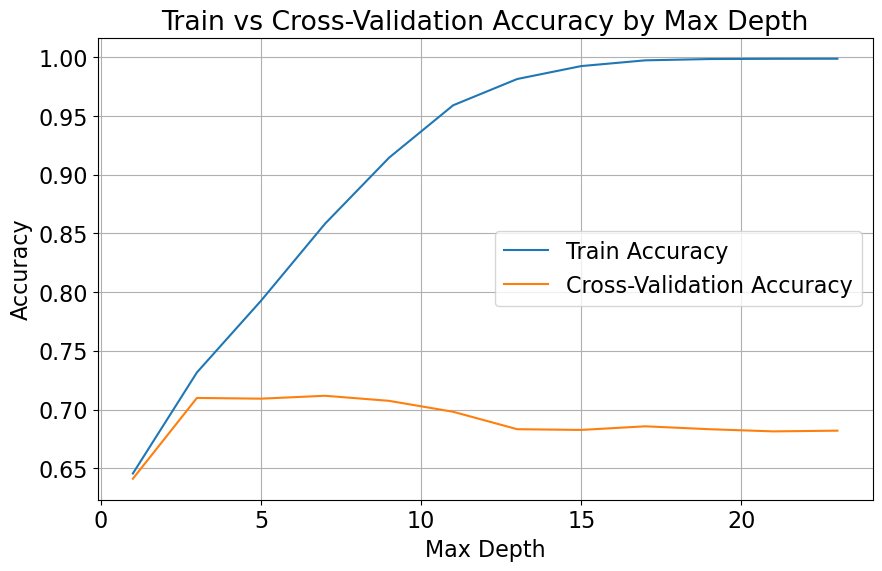

In [14]:
train_scores = []
cv_scores = []

for max_depth in depths:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=123)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    train_scores.append(np.mean(scores['train_score']))
    cv_scores.append(np.mean(scores['test_score']))

plt.figure(figsize=(10, 6))
plt.plot(depths, train_scores, label='Train Accuracy')
plt.plot(depths, cv_scores, label='Cross-Validation Accuracy')
plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Train vs Cross-Validation Accuracy by Max Depth')
plt.legend()
plt.grid(True)

max_depth_plot = plt.gcf() 

<br><br>

### 3.2 `max_depth` and the fundamental tradeoff

_Points: 2_

**Your tasks:**

Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy.

<div class="alert alert-warning">

Solution_3.2
    
</div>

The above plot shows that the accuracy of training and validation scores improves up to a certain depth for max_depth, but after that the discrepancy between the two increases. This suggests that setting max_depth higher may overfit the training data.

<br><br>

### 3.3 Picking a reasonable value for `max_depth`

_Points: 2_

**Your tasks:**

From these results, what value for max_depth would you pick as the optimal value? Store it in the variable called `best_max_depth` below. 

<div class="alert alert-warning">

Solution_3.3
    
</div>

In [15]:
best_max_depth = 3

<br><br>

### 3.4 Final assessment on the test set

_Points: 3_

Remember the test set you created way back at the beginning of this assignment? Let's use it now to see if our cross-validation score from the previous exercise is trustworthy. 

**Your tasks:**
1. Train a decision tree classifier using the optimal _max_depth_ you chose in the previous exercise on the entire training set.
2. Compute and store it in a variable called `test_score`. 

<div class="alert alert-warning">

Solution_3.4
    
</div>

In [16]:
optimal_tree = DecisionTreeClassifier(max_depth=3, random_state=123)
optimal_tree.fit(X_train, y_train)
test_score = optimal_tree.score(X_test, y_test)

print("Test accuracy:", test_score)

Test accuracy: 0.6683168316831684


<br><br>

### 3.5 Analysis

_Points: 5_

**Your tasks:**

1. How do the test scores compare to the cross-validation scores? Briefly discuss.
2. Why can't you simply pick the value of `max_depth` that gives the best accuracy on the training data? (Answer in maximum 2 to 3 sentences.)
3. Do you think that the max_depth you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

<div class="alert alert-warning">

Solution_3.5
    
</div>

1.  The test score was lower than the cross-validation scores. It indicates that the model is still overfitting to the training data.
2.  Picking the value of max_depth that gives the best accuracy on the training data is not good because it can lead to overfitting. The model can become too complex, capturing noise and specific patterns in the training data that do not generalize to new, unseen data
3.  I don't think so since user preferences can vary widely, and factors like geographical location, time period, and demographic differences can introduce variability. 

<br><br><br><br>

## Exercise 4: Conceptual questions

_Points: 3_

Consider the dataset below, which has $6$ examples and $2$ features:

$$X = \begin{bmatrix}5 & 2\\4 & 3\\  2 & 2\\ 10 & 10\\ 9 & -1\\ 9& 9\end{bmatrix}, \quad y = \begin{bmatrix}-1\\-1\\+1\\+1\\+1\\+1\end{bmatrix}.$$

1. Say we fit a decision stump (depth 1 decision tree) and the first split is on the first feature (left column) being less than 5.5. What would we predict in the "true" and "false" cases here?
2. What training accuracy would the above stump get on this data set?
3. Can we obtain 100% accuracy with a single decision stump in this particular example?

<div class="alert alert-warning">

Solution_4
    
</div>

1 predict: [-1,-1,-1,+1,+1,+1]
2 5/6
3 No, since third exmaple is +1 not -1

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using [PrairieLearn](https://ca.prairielearn.com/pl/course_instance/6697).

Congratulations on working with your first machine learning model! Well done 👏👏!

![](./img/eva-well-done.png)